In [28]:
import re
import nltk
import string
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from numpy import sqrt
from numpy import argmax
from sklearn import metrics
from zipfile import ZipFile 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
file_name = "/content/drive/My Drive/2477_4140_compressed_training.1600000.processed.zip"
data = ZipFile(file_name, 'r') 
path = data.filename
df = pd.read_csv(path, encoding='latin-1',header=None,names=['target','text'],usecols=[0,5])

In [3]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
pd.value_counts(df.target)

4    800000
0    800000
Name: target, dtype: int64

In [5]:
df.target = df.target.replace(4, 1)
print("After Replacing 4 with 1 one's\n", pd.value_counts(df.target))

After Replacing 4 with 1 one's
 1    800000
0    800000
Name: target, dtype: int64


Text(0.5, 1.0, 'Sentiment Data Distribution')

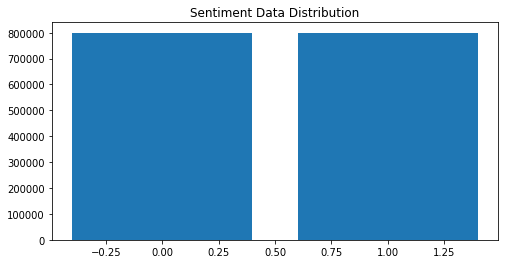

In [6]:
val_count = df.target.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [7]:
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
punctuation=[]
for i in string.punctuation:
    punctuation.append(i)

def text_preprocessing(text):
    re_for_text_cleaning=r"@\S+ |https.\S+ |http.\S+|[^a-zA-Z0-9]|#\S+"
    text = re.sub(re_for_text_cleaning," ",text.lower())
    sentence=[]
    for word in text.split():
        if word not in stop_words:
            if word not in punctuation:
                sentence.append(stemmer.stem(word))
    return " ".join(sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
df.text=df.text.apply(lambda x: text_preprocessing(x) )

In [10]:
df

,target,text
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdb com cool hear old walt interview
1599997,1,readi mojo makeov ask detail
1599998,1,happi 38th birthday boo alll time tupac amaru ...


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df["text"],df["target"], test_size=0.10, random_state=48)

In [12]:
training_sentences = []
testing_sentences = []

print('prepearing train and test...')
# Train
for s in X_train:
    training_sentences.append(s)
#Test
for s in X_test:
    testing_sentences.append(s)


prepearing train and test...


In [13]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [14]:
vocab_len=40000
max_len=150
truncating_type="post"
emb_dimension=100
oov_string= "<OOV>"
tokenizer = Tokenizer(num_words = vocab_len, oov_token= oov_string)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_len, truncating=truncating_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len)

In [15]:
model= tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len,emb_dimension),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(254,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         4000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 254)               260350    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [16]:
history = model.fit(padded,
                    y_train,
                    epochs=2,
                    batch_size=100,
                    validation_data=(testing_padded,y_test)
                    )

Epoch 1/2
14400/14400 [==============================] - 990s 69ms/step - loss: 0.4660 - accuracy: 0.7770 - val_loss: 0.4523 - val_accuracy: 0.7835
Epoch 2/2
14400/14400 [==============================] - 1005s 70ms/step - loss: 0.4288 - accuracy: 0.7996 - val_loss: 0.4462 - val_accuracy: 0.7896


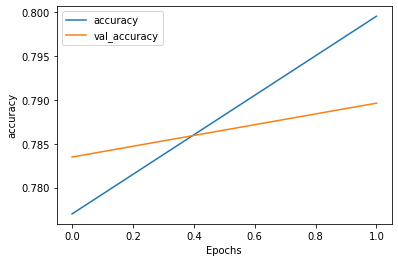

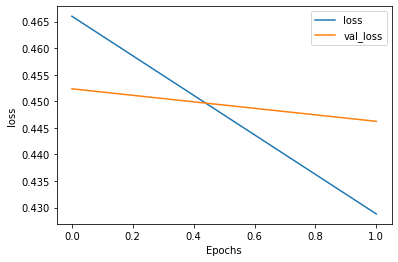

In [17]:
def plotgraph (history,string):
  plt.plot(history.history[string])
  plt.plot(history.history["val_"+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string,"val_"+string])
  plt.show()

plotgraph (history,"accuracy")
plotgraph (history,"loss")

In [18]:
preds = model.predict(testing_padded)
print(classification_report(y_test, preds.round()))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     80185
           1       0.79      0.79      0.79     79815

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



Text(33.0, 0.5, 'True')

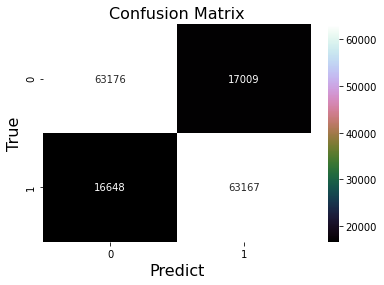

In [19]:
cf_matrix = confusion_matrix(y_test, preds.round())
f,ax=plt.subplots()
sns.heatmap(cf_matrix,annot=True,cmap='cubehelix',fmt="05") 
ax.set_title('Confusion Matrix',fontsize=16)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('True',fontsize=16) 

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=None)
thresholds

array([1.9988873e+00, 9.9888724e-01, 9.9807417e-01, ..., 8.0268690e-04,
       8.0205535e-04, 4.0465215e-04], dtype=float32)

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.490812, G-Mean=0.790


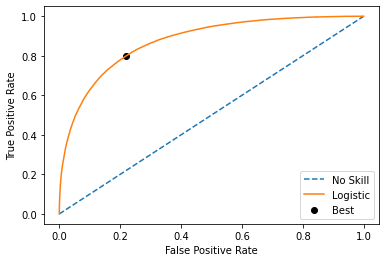

In [22]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [23]:
df

,target,text
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdb com cool hear old walt interview
1599997,1,readi mojo makeov ask detail
1599998,1,happi 38th birthday boo alll time tupac amaru ...


In [54]:
X_train, X_test, y_train, y_test = train_test_split(df["text"],df["target"], test_size=0.2,random_state=2316)

In [55]:
vectoriser = TfidfVectorizer(ngram_range=(1,3), max_features=50000)
X_train=vectoriser.fit_transform(X_train)
X_test=vectoriser.fit_transform(X_test)

In [68]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    f,ax=plt.subplots()
    sns.heatmap(cf_matrix,annot=True,cmap='cubehelix',fmt="05") 
    ax.set_title('Confusion Matrix',fontsize=16)
    ax.set_xlabel('Predict',fontsize=16)
    ax.set_ylabel('True',fontsize=16) 


              precision    recall  f1-score   support

           0       0.60      0.58      0.59    159528
           1       0.59      0.62      0.60    160472

    accuracy                           0.60    320000
   macro avg       0.60      0.60      0.60    320000
weighted avg       0.60      0.60      0.60    320000



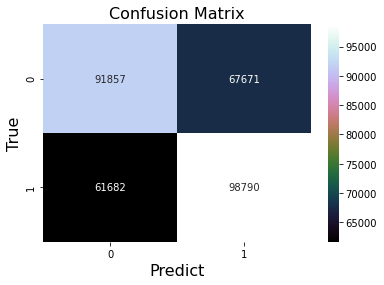

In [69]:
BNBmodel = BernoulliNB(alpha = 2).fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.55      0.46      0.50    159528
           1       0.54      0.63      0.58    160472

    accuracy                           0.54    320000
   macro avg       0.54      0.54      0.54    320000
weighted avg       0.54      0.54      0.54    320000



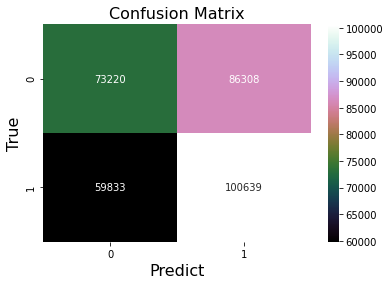

In [70]:
SVCmodel = LinearSVC().fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.55      0.42      0.48    159528
           1       0.53      0.66      0.59    160472

    accuracy                           0.54    320000
   macro avg       0.54      0.54      0.53    320000
weighted avg       0.54      0.54      0.53    320000



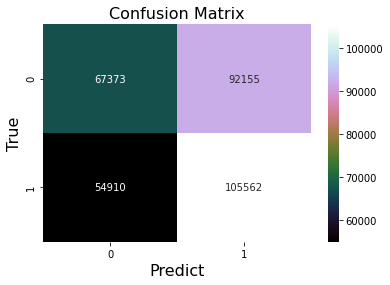

In [71]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1).fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.59      0.61      0.60    159528
           1       0.60      0.58      0.59    160472

    accuracy                           0.59    320000
   macro avg       0.59      0.59      0.59    320000
weighted avg       0.59      0.59      0.59    320000



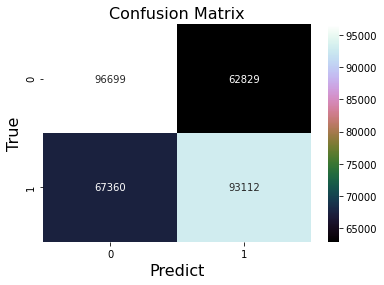

In [72]:
Multinomial_model = MultinomialNB().fit(X_train,y_train)
model_Evaluate(Multinomial_model)